In [1]:
import os

import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine, URL

from splot import esda as esdaplot
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn
import contextily

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/Users/

In [2]:
db_url = URL.create(
    drivername="postgresql",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ["DB_HOST"],
    port=os.environ["DB_PORT"],
    database=os.environ["DB_NAME"],
)

db = create_engine(db_url)

In [3]:
incidents_gdf = gpd.read_postgis("SELECT * FROM geo_accidents", db)  

In [4]:
ctu_gdf = gpd.read_postgis("SELECT * FROM ctu_accidents", db) # MAY NEED TO CHANGE TABLE FOR TESTING

In [40]:
# Spatial Join
join_gdf = gpd.sjoin(ctu_gdf, incidents_gdf, how='left', predicate='contains')

In [41]:
point_counts = join_gdf.groupby("id").count().geom.rename("n_points")

ctu_gdf_new = ctu_gdf.set_index('id').join(point_counts)

#ctu_gdf['POINT_COUNT'] = point_counts
ctu_gdf_new['n_points'] = ctu_gdf_new['n_points'].fillna(0).astype(int)

In [42]:
ctu_gdf_new

,ctu_name,class,county,pop,total_road_length,aadt_sum,aadt_mean,geom,total_incident_count,predicted_count,...,lmi_p,lmi_sig,lmi_label,POINT_COUNT,LMI,LMI_P,LMI_SIG,LMI_Q,LMI_LABEL,n_points
id,,,,,,,,,,,,,,,,,,,,,
1,Augsburg,TOWNSHIP,Marshall,73,531742.572,945.0,189.000000,"POLYGON ((-96.64940 48.54366, -96.64941 48.543...",None,None,...,None,None,None,0,-0.050688,0.262,0,2,Non-Significant,1
2,Danielson,TOWNSHIP,Meeker,282,537483.168,1642.0,328.400000,"POLYGON ((-94.63485 45.06580, -94.63486 45.051...",None,None,...,None,None,None,1,0.122117,0.204,0,3,Non-Significant,1
3,Bluffton,CITY,Otter Tail,208,80168.262,7190.0,2396.666667,"POLYGON ((-95.21819 46.45607, -95.23909 46.455...",None,None,...,None,None,None,1,-0.812237,0.022,1,2,LH,5
4,Dalbo,TOWNSHIP,Isanti,801,390959.648,1644.0,182.666667,"POLYGON ((-93.38911 45.73072, -93.38904 45.716...",None,None,...,None,None,None,5,-0.013707,0.485,0,4,Non-Significant,1
5,Hallock,TOWNSHIP,Kittson,83,572900.217,3173.0,352.555556,"POLYGON ((-96.93072 48.80388, -96.93067 48.789...",None,None,...,None,None,None,1,0.096864,0.303,0,3,Non-Significant,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,Saint Wendel,TOWNSHIP,Stearns,2131,544042.689,25150.0,2794.444444,"POLYGON ((-94.26376 45.67379, -94.26386 45.659...",None,None,...,None,None,None,1,-0.026594,0.309,0,2,Non-Significant,5
2741,Hampton,TOWNSHIP,Dakota,828,563290.257,51289.0,2229.956522,"POLYGON ((-93.01504 44.63030, -93.00023 44.630...",None,None,...,None,None,None,5,-0.030940,0.322,0,4,Non-Significant,2
2742,Lucas,TOWNSHIP,Lyon,208,554088.276,10636.0,664.750000,"MULTIPOLYGON (((-95.60402 44.62998, -95.60406 ...",None,None,...,None,None,None,2,0.058346,0.323,0,3,Non-Significant,9


### Local Moran's I

In [7]:
from pysal.explore import esda
from pysal.lib import weights

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [43]:
# Extract the points count as a NumPy array
data = ctu_gdf_new['n_points'].values

# Create a weights matrix (W) for the spatial relationship between polygons
# You can use different methods to construct the weights matrix, e.g., queen or rook
w = weights.Queen.from_dataframe(ctu_gdf_new)

# Perform Local Moran's I analysis
moran_loc = esda.Moran_Local(data, w)

# Add the Local Moran's I values and p-values as columns in the GeoDataFrame
ctu_gdf_new['LMI'] = moran_loc.Is
ctu_gdf_new['LMI_P'] = moran_loc.p_sim
ctu_gdf_new['LMI_SIG'] = 1 * (moran_loc.p_sim < 0.05)
ctu_gdf_new['LMI_Q'] = moran_loc.q

# LABELS
labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
ctu_gdf_new["LMI_LABEL"] = pd.Series(
    moran_loc.q * (1 * (moran_loc.p_sim < 0.05)),
    index=ctu_gdf_new.index
).map(labels)

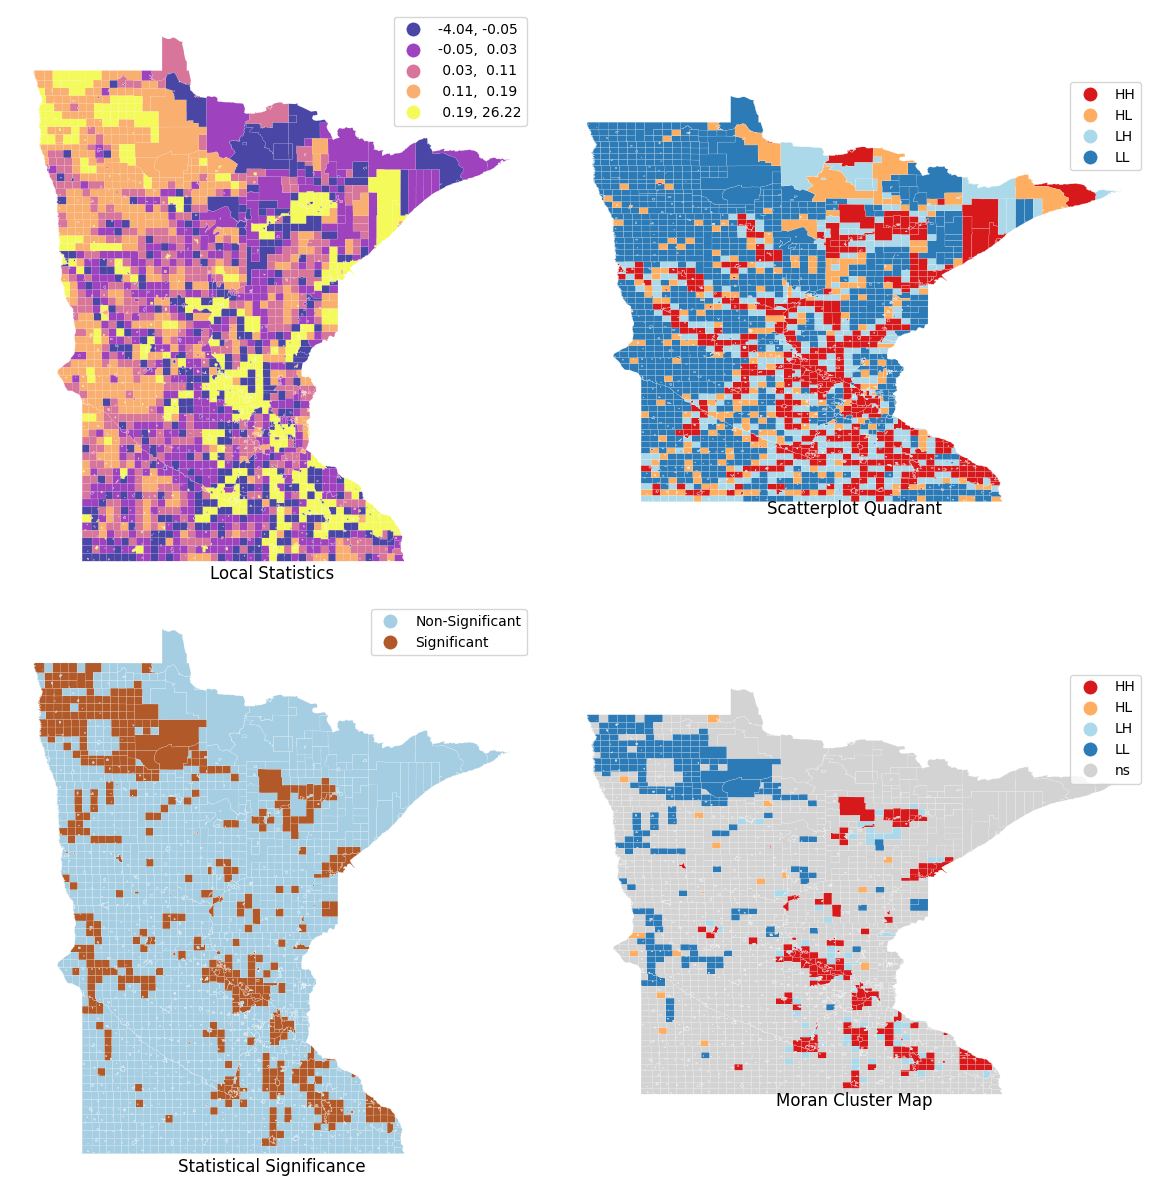

In [44]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
ctu_gdf_new.assign(
    Is=moran_loc.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(moran_loc, ctu_gdf_new, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (moran_loc.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=ctu_gdf_new.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
ctu_gdf_new.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(moran_loc, ctu_gdf_new, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

## ADBSCAN

In [26]:
from esda.adbscan import ADBSCAN, get_cluster_boundary, remap_lbls
import numpy as np

In [45]:
intersects_gdf = gpd.sjoin(incidents_gdf, ctu_gdf, how='inner', predicate='intersects')

# Extract the filtered points GeoDataFrame
filtered_points_gdf = intersects_gdf[incidents_gdf.columns]

In [46]:
filtered_points_gdf["X"] = filtered_points_gdf.geometry.x
filtered_points_gdf["Y"] = filtered_points_gdf.geometry.y

# Get clusters
adbs = ADBSCAN(0.15, filtered_points_gdf.shape[0] * 0.01, pct_exact=0.5, reps=50, keep_solus=True)
np.random.seed(1234)
adbs.fit(filtered_points_gdf)

/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/lukezaruba/miniconda3/envs/mnaccidents-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


ADBSCAN(eps=0.15, keep_solus=True, min_samples=98.33, pct_exact=0.5, reps=50)

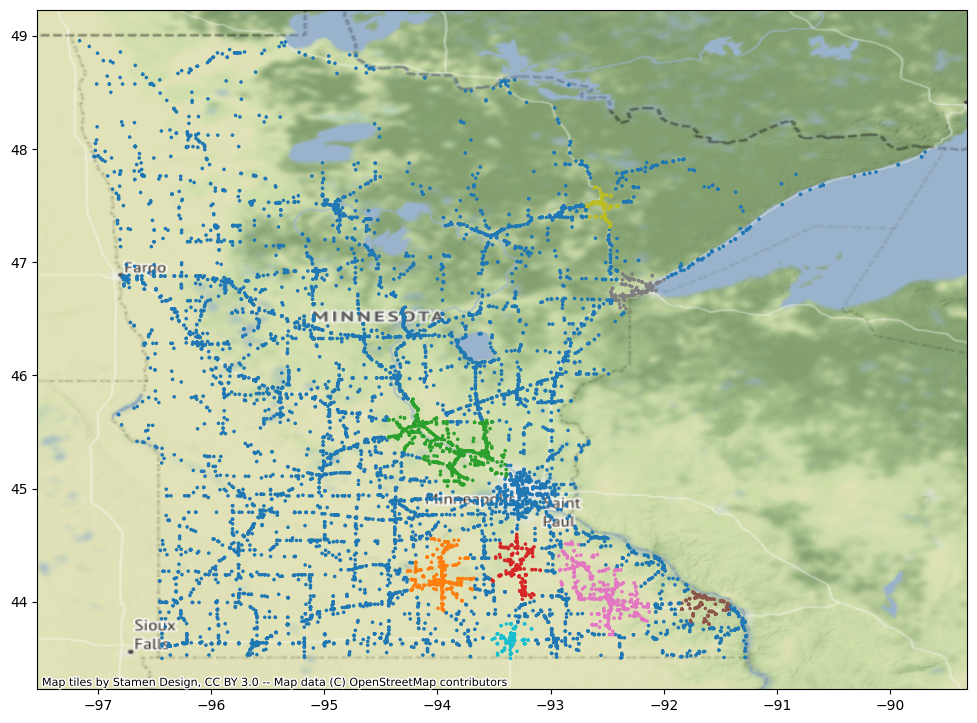

In [47]:
ax = filtered_points_gdf.assign(lbls=adbs.votes["lbls"])\
    .plot(column="lbls",
        categorical=True,
        markersize=2.5,
        figsize=(12, 12)
    )
contextily.add_basemap(ax, crs=filtered_points_gdf.crs.to_string());

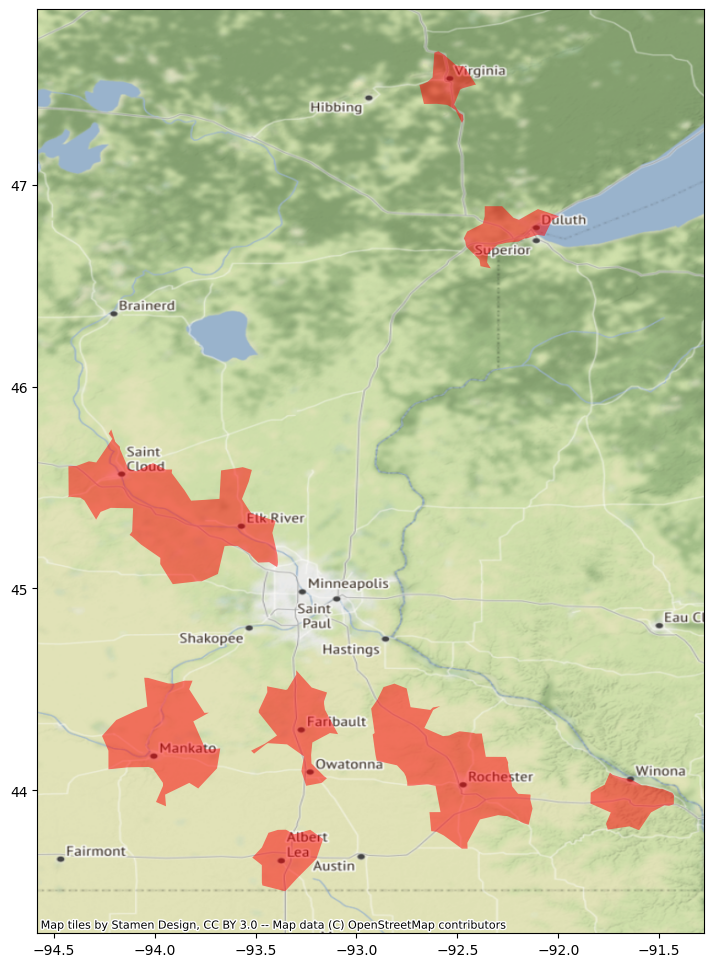

In [48]:
polys = get_cluster_boundary(adbs.votes["lbls"], filtered_points_gdf, crs=filtered_points_gdf.crs)

ax = polys.plot(alpha=0.5, color="red", figsize=(12, 12))
contextily.add_basemap(ax, crs=polys.crs.to_string());

### Uploading Results to DB

In [22]:
# CTU LMI Metrics
# update_columns = ctu_gdf[["id", "LMI", "LMI_P", "LMI_SIG", "LMI_Q", "LMI_LABEL"]]

# updates = list(update_columns.itertuples(index=False, name=None))

# updates

# with db.connect() as connection:
#     # UPDATE CTU VALUES
#     for ctu in updates:
#         update_query = f"""
#         UPDATE TABLE ctu_accidents
#         SET lmi_i = {ctu[1]},
#         SET lmi_p = {ctu[2]},
#         SET lmi_sig = {ctu[3]},
#         SET lmi_q = {ctu[4]},
#         SET lmi_label = {ctu[5]}
#         WHERE icr = {ctu[0]}
#         """

#         connection.execute(text(update_query))
#         connection.commit()


[(1, -0.19617921233268604, 0.156, 0, 4, 'Non-Significant'),
 (2, -0.19617921233268604, 0.156, 0, 4, 'Non-Significant'),
 (3, 0.6072771438477474, 0.378, 0, 1, 'Non-Significant'),
 (4, 0.20554896575753062, 0.366, 0, 1, 'Non-Significant'),
 (5, -0.3970433013777944, 0.032, 1, 4, 'HL'),
 (6, -0.08139973287833836, 0.484, 0, 4, 'Non-Significant'),
 (7, 0.3394583584542696, 0.268, 0, 1, 'Non-Significant'),
 (8, -0.5979073904229028, 0.02, 1, 4, 'HL'),
 (9, 0.07163957306079181, 0.387, 0, 1, 'Non-Significant'),
 (10, 0.6072771438477474, 0.378, 0, 1, 'Non-Significant'),
 (11, 0.6072771438477474, 0.375, 0, 1, 'Non-Significant'),
 (12, -0.19617921233268604, 0.126, 0, 4, 'Non-Significant'),
 (13, 0.0716395730607918, 0.458, 0, 1, 'Non-Significant'),
 (14, -0.19617921233268604, 0.126, 0, 4, 'Non-Significant'),
 (15, -0.46399799772616374, 0.312, 0, 4, 'Non-Significant'),
 (16, -0.9996355685131195, 0.001, 1, 4, 'HL'),
 (17, 0.6072771438477474, 0.375, 0, 1, 'Non-Significant'),
 (18, 0.6072771438477474, 0.3

In [27]:
# ADBSCAN Polygons
# cluster_boundary_gdf = gpd.GeoDataFrame(polys)

# cluster_boundary_gdf.insert(0, "id", range(0, len(cluster_boundary_gdf)))

# cluster_boundary_gdf.columns = ["id", "geom"]

# cluster_boundary_gdf.to_postgis(...)

,id,geom
1,0,"POLYGON ((-92.01426 43.97805, -92.02893 43.941..."
12,1,"POLYGON ((-92.42685 46.69974, -92.42751 46.699..."
19,2,"POLYGON ((-91.55379 44.02126, -91.49682 44.007..."
2,3,"POLYGON ((-94.10690 45.39745, -94.19991 45.453..."
4,4,"POLYGON ((-93.93179 44.31089, -93.93141 44.282..."
6,5,"POLYGON ((-92.91907 47.43475, -92.88755 47.479..."
